In [1]:
import zipfile

z= zipfile.ZipFile('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
z.extractall()
z= zipfile.ZipFile('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
z.extractall()
z= zipfile.ZipFile('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')
z.extractall()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
! pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.1 MB/s eta 0:00:00


In [4]:
import contractions
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
from nltk.tokenize import word_tokenize
import re 
from nltk.corpus import stopwords

In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

from sklearn import metrics

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
stopwords = stopwords.words('english')
print(stopwords.remove('not'))
# print(stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
None


In [7]:
df = pd.read_csv("/kaggle/working/train.csv", index_col = 'id')
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [9]:
df.duplicated().sum()

0

In [10]:
for col in df.select_dtypes("int"):
    print(df[col].value_counts())
    print("----------------------")

toxic
0    144277
1     15294
Name: count, dtype: int64
----------------------
severe_toxic
0    157976
1      1595
Name: count, dtype: int64
----------------------
obscene
0    151122
1      8449
Name: count, dtype: int64
----------------------
threat
0    159093
1       478
Name: count, dtype: int64
----------------------
insult
0    151694
1      7877
Name: count, dtype: int64
----------------------
identity_hate
0    158166
1      1405
Name: count, dtype: int64
----------------------


In [11]:
def drop_stop_words(text):
    words = word_tokenize(text)
    wordsFiltered = []
    for w in words:
        if w.lower() not in stopwords:
            wordsFiltered.append(w)

    wordsFiltered = " ".join(wordsFiltered)
    return wordsFiltered


def remove_elongation(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1", text)


def processing(text):
    try:
        url_pattern = r'https?://\S+|www\.\S+'
        text = re.sub(url_pattern, '', text)
        
        text = re.sub(r'#', '', text).strip()
        
        text = contractions.fix(text) # remove_punc
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        extract_words = re.compile(r'\W+')  # remove_non_word
        text = extract_words.sub(' ', text)

        text = drop_stop_words(text)
        text = re.sub('[^a-zA-Z\s]', '', text) # remove_non_English_word
        
        text = re.sub(r'user(?:name)?\s', '', text) # remove_username
        text = remove_elongation(text)

        return text
    except Exception as e:
        print("Error processing text:", e)
        return text  # Return the original text if an error occurs

In [12]:
df_copy = df.copy()

In [13]:
df_copy['comment_text'] = df_copy["comment_text"].apply(lambda x: processing(x))

In [14]:
df_copy.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [15]:
df_copy.duplicated().sum()

1311

In [16]:
df_copy.drop_duplicates(inplace = True)

In [17]:
df_copy.columns.tolist()

['comment_text',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

In [18]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158260 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   158260 non-null  object
 1   toxic          158260 non-null  int64 
 2   severe_toxic   158260 non-null  int64 
 3   obscene        158260 non-null  int64 
 4   threat         158260 non-null  int64 
 5   insult         158260 non-null  int64 
 6   identity_hate  158260 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


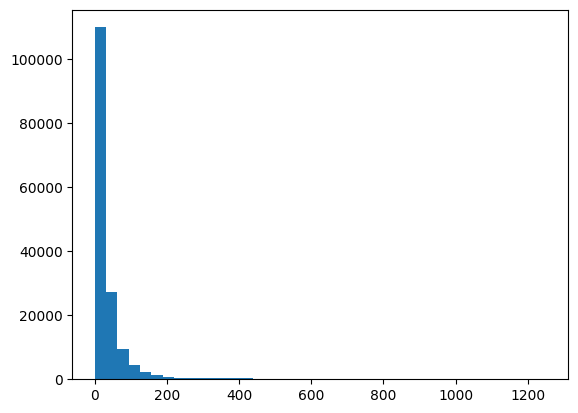

Avg: 34.43515733602932
Max: 1250



In [19]:
def length_plot(data):
    length = [len(sentence.split()) for sentence in data]
    plt.hist(length, bins = 40)
    plt.show()
    print(f'Avg: {np.average(length)}')
    print(f'Max: {np.max(length)}\n')
    
length_plot(df_copy["comment_text"])

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
tok = Tokenizer()
tok.fit_on_texts(df_copy['comment_text'])
words = tok.word_index

In [21]:
len(words)

215110

In [22]:
sequence = tok.texts_to_sequences(df_copy['comment_text'])

In [23]:
idx2word = {words[word]: word for word in words.keys()}

In [24]:
def reconstruct(tokens):
    text = []
    for token in tokens:
        text.append(idx2word[token])
    return " ".join(text)
reconstruct(sequence[0])

'explanation edits made hardcore metallica fan reverted not vandalisms closure gas voted new york dolls fac please not remove template talk page since retired now'

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_sequence_len = 150
x_padded = pad_sequences(sequence, padding="post", maxlen=max_sequence_len)
x_padded

array([[  507,    43,    44, ...,     0,     0,     0],
       [91809,  2285,  1239, ...,     0,     0,     0],
       [  296,   308,    48, ...,     0,     0,     0],
       ...,
       [32479,  7003,   530, ...,     0,     0,     0],
       [  399,     9,   101, ...,     0,     0,     0],
       [   48,     1,    12, ...,     0,     0,     0]], dtype=int32)

In [26]:
df_label = df_copy.iloc[:, 1:]
df_label

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0000997932d777bf,0,0,0,0,0,0
000103f0d9cfb60f,0,0,0,0,0,0
000113f07ec002fd,0,0,0,0,0,0
0001b41b1c6bb37e,0,0,0,0,0,0
0001d958c54c6e35,0,0,0,0,0,0
...,...,...,...,...,...,...
ffe987279560d7ff,0,0,0,0,0,0
ffea4adeee384e90,0,0,0,0,0,0
ffee36eab5c267c9,0,0,0,0,0,0


In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_padded, df_label, test_size=0.1, random_state=42)

In [28]:
x_train.shape

(142434, 150)

In [29]:
x_test

array([[  772,     0,     0, ...,     0,     0,     0],
       [   21,    44,  1831, ...,     0,     0,     0],
       [ 2358,     9,    48, ...,     0,     0,     0],
       ...,
       [  681, 19109,   492, ...,     0,     0,     0],
       [ 6455,  2084,  3505, ...,     0,     0,     0],
       [   11, 55079, 71854, ...,     0,     0,     0]], dtype=int32)

In [30]:
VOCAB_SIZE = len(words) + 1
VOCAB_SIZE

215111

In [31]:
VECTOR_FEATURES = 128
lstm_bi = tf.keras.models.Sequential([    
    tf.keras.layers.Embedding(VOCAB_SIZE, VECTOR_FEATURES),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

In [32]:
roc_auc_metric = tf.keras.metrics.AUC()
lstm_bi.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr = 1e-03),
              metrics=["accuracy"])

In [33]:
history = lstm_bi.fit(x_train, y_train, epochs=5, batch_size=128,
                    validation_data=(x_test, y_test))

Epoch 1/5
1113/1113 [==============================] - 170s 141ms/step - loss: 0.0765 - accuracy: 0.9047 - val_loss: 0.0541 - val_accuracy: 0.9947
Epoch 2/5
1113/1113 [==============================] - 75s 68ms/step - loss: 0.0447 - accuracy: 0.9788 - val_loss: 0.0511 - val_accuracy: 0.9947
Epoch 3/5
1113/1113 [==============================] - 62s 56ms/step - loss: 0.0377 - accuracy: 0.9822 - val_loss: 0.0538 - val_accuracy: 0.9946
Epoch 4/5
1113/1113 [==============================] - 58s 52ms/step - loss: 0.0332 - accuracy: 0.9865 - val_loss: 0.0586 - val_accuracy: 0.9947
Epoch 5/5
1113/1113 [==============================] - 56s 50ms/step - loss: 0.0298 - accuracy: 0.9695 - val_loss: 0.0634 - val_accuracy: 0.9941


In [34]:
test_loss, test_acc = lstm_bi.evaluate(x_test, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

495/495 [==============================] - 6s 11ms/step - loss: 0.0634 - accuracy: 0.9941
Test Loss: 0.06343528628349304
Test Accuracy: 0.9940603971481323


In [35]:
test_df = pd.read_csv('/kaggle/working/test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [36]:
test_df['comment_text'] = test_df["comment_text"].apply(lambda x: processing(x))
test_df

Error processing text: string index out of range
Error processing text: string index out of range
Error processing text: string index out of range
Error processing text: string index out of range


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule succesful ever hating sad mof...
1,0000247867823ef7,RfC title fine GOING
2,00013b17ad220c46,Sources Zawe Ashton Lapland
3,00017563c3f7919a,look back source information updated correct f...
4,00017695ad8997eb,not anonymously edit articles
...,...,...
153159,fffcd0960ee309b5,totally agree stuff nothing toolongcrap
153160,fffd7a9a6eb32c16,Throw field home plate get faster throwing cut...
153161,fffda9e8d6fafa9e,Okinotorishima categories see changes agree co...
153162,fffe8f1340a79fc2,One founding nations EU Germany Law Return qui...


In [37]:
test = tok.texts_to_sequences(test_df['comment_text'])
test = pad_sequences(test, padding="post", maxlen=max_sequence_len)
predicted = lstm_bi.predict(test)

4787/4787 [==============================] - 44s 9ms/step


In [38]:
predict_df = pd.DataFrame(predicted, columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [39]:
sub = pd.concat((test_df['id'], predict_df), axis = 1)

In [40]:
sub.to_csv("submission.csv", index= False)